# **РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ**

##

## **Отчет по лабораторной работе "Трансформеры"**

---



### **Студент** : Озьяс Стев Икнэль Дани   ------  **Группа** : НКНбд-01-21



**Вариант 7**

1. Набор данных oxford_iiit_pet с изменением разрешения до 96x96

2. Классы с метками 10,12,21,32,35

3. Требования к архитектуре сети MLP:

Последовательный API со списком слоев при создании

Функция потерь: категориальная кросс-энтропия

Кол-во скрытых слоев 4

Кол-во нейронов 30 в первом скрытом слое, увеличивающееся на 20 с каждым последующим скрытым слоем

Использование слоев с регуляризацией L1

4. Требования к архитектуре сети трансформер:

Функция потерь: разреженная категориальная кросс-энтропия

5. Показатель качества многоклассовой классификации:

минимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.

#### Задание (10 баллов)

Для закрепленного за Вами варианта работы:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.
2. Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте по одному изображению из каждого класса, подписывая изображение меткой класса.
3. Постройте нейронные сети различных архитектур (MLP, CNN, RNN, трансформер) для задачи многоклассовой классификации изображений (архитектуры и требования к сетям указаны в индивидуальном задании), используя функции потерь, указанные в индивидуальном задании. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Обучайте нейронные сети с использованием валидационной выборки, сформированной в п. 1. Останавливайте переобучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд.
4. Вычислите и выведите в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) для обучающей и тестовой выборок.
5. Визуализируйте кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).
6. Оцените качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите название нейронной сети с лучшим качеством.




In [ ]:
# Добавляем библиотеки, которыми мы воспользуемся в дальнейшем:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image, ImageOps
from keras import regularizers
from sklearn.model_selection import train_test_split
import time
import sys

In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # Keras v.3 !

In [ ]:
%load_ext autoreload
%autoreload 2
import keras
from keras import layers, models, losses, callbacks
from keras import ops

## **Задание 1**

Считаем из tensorflow набор данных **oxford_iiit_pet**:

(500, 500, 3)
(96, 96, 3)


((3680, 5), (2568, 5), (1101, 5))

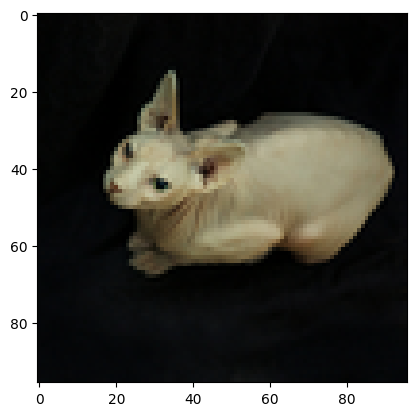

In [ ]:
ds = tfds.load("oxford_iiit_pet", split=['train', 'test'])

#Сначала разбиение на обучающую и тестовую выборки

df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

print(df_train.iloc[0]['image'].shape)

#изменение разрешения до 60x90
df_train_resized = []
df_test_resized = []

for i in range(len(df_train)):
  img = Image.fromarray(df_train.iloc[i]['image'])
  img = img.resize((96,96),Image.Resampling.LANCZOS)
  df_train_resized.append(np.array(img))

df_train['image'] = df_train_resized

for i in range(len(df_test)):
  img = Image.fromarray(df_test.iloc[i]['image'])
  img = img.resize((96,96),Image.Resampling.LANCZOS)
  df_test_resized.append(np.array(img))

df_test['image'] = df_test_resized

# размер после изменения
print(df_train.iloc[0]['image'].shape)
plt.imshow(Image.fromarray(df_train.iloc[0]['image']));

#Теперь разбиение на обучающую, валидационную и тестовую выборки
# Обучающий набор имеет размер размер 0,5 от исходного набора oxford_iiit_pet
# Тестовый набор имеет размер 0.35 а валидационный набор 0,15

test_size= int(0.7* len(df_test))
df_test, df_val = df_test[:test_size], df_test[test_size:]

df_train.shape, df_test.shape, df_val.shape

## **Задание 2**

Оставим в наборе изображения 5 классов **с метками 10,12,21,32,35**

In [ ]:
df_train2 = pd.DataFrame()
df_test2 = pd.DataFrame()
df_val2 = pd.DataFrame()

selected_classes=[10,12,21,32,35]

df_train2 = df_train.loc[df_train['label'].isin(selected_classes)]
df_test2 = df_test.loc[df_test['label'].isin(selected_classes)]
df_val2 = df_val.loc[df_val['label'].isin(selected_classes)]

df_train2.shape, df_test2.shape, df_val2.shape

((495, 5), (343, 5), (157, 5))

In [ ]:
del df_train
del df_test
del df_val

Здесь очевидно что у нас теперь толкьо 4 класса

In [ ]:
df_train2['label'].value_counts()

label
10    100
21    100
35    100
32     99
12     96
Name: count, dtype: int64

In [ ]:
df_train2.head()

,file_name,image,label,segmentation_mask,species
1,b'english_cocker_spaniel_135.jpg',"[[[12, 22, 6], [17, 28, 11], [3, 9, 2], [3, 10...",12,"[[[3], [3], [3], [3], [3], [3], [3], [3], [3],...",1
3,b'Siamese_161.jpg',"[[[100, 123, 112], [100, 123, 112], [99, 123, ...",32,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0
12,b'Siamese_175.jpg',"[[[240, 201, 42], [240, 200, 39], [238, 201, 6...",32,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0
13,b'chihuahua_187.jpg',"[[[2, 6, 5], [6, 10, 9], [17, 23, 21], [13, 23...",10,"[[[3], [3], [3], [3], [3], [3], [3], [3], [3],...",1
17,b'english_cocker_spaniel_185.jpg',"[[[10, 18, 7], [17, 28, 15], [11, 14, 9], [7, ...",12,"[[[3], [2], [2], [2], [2], [2], [2], [2], [2],...",1


Переименуем классы с значениями от 0 до 4

In [ ]:
for cl in selected_classes:
  df_train2.loc[df_train2['label'] == cl, 'label'] = selected_classes.index(cl)
  df_test2.loc[df_test2['label'] == cl, 'label'] = selected_classes.index(cl)
  df_val2.loc[df_val2['label'] == cl, 'label'] = selected_classes.index(cl)

In [ ]:
df_train2['label'].value_counts()

label
0    100
2    100
4    100
3     99
1     96
Name: count, dtype: int64

In [ ]:
df_train2.head()

,file_name,image,label,segmentation_mask,species
1,b'english_cocker_spaniel_135.jpg',"[[[12, 22, 6], [17, 28, 11], [3, 9, 2], [3, 10...",1,"[[[3], [3], [3], [3], [3], [3], [3], [3], [3],...",1
3,b'Siamese_161.jpg',"[[[100, 123, 112], [100, 123, 112], [99, 123, ...",3,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0
12,b'Siamese_175.jpg',"[[[240, 201, 42], [240, 200, 39], [238, 201, 6...",3,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0
13,b'chihuahua_187.jpg',"[[[2, 6, 5], [6, 10, 9], [17, 23, 21], [13, 23...",0,"[[[3], [3], [3], [3], [3], [3], [3], [3], [3],...",1
17,b'english_cocker_spaniel_185.jpg',"[[[10, 18, 7], [17, 28, 15], [11, 14, 9], [7, ...",1,"[[[3], [2], [2], [2], [2], [2], [2], [2], [2],...",1


Визуализируем по одному изображению из каждого класса, подписывая изображение меткой класса.

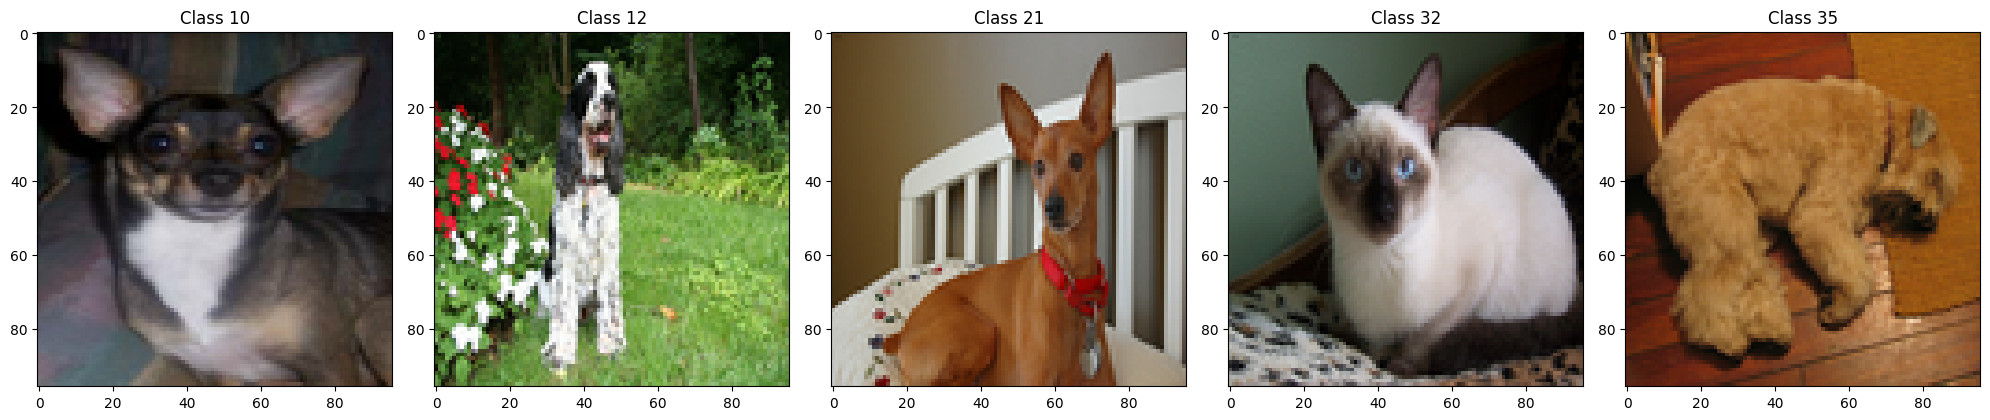

In [ ]:
num_classes = len(selected_classes)
fig = plt.figure(figsize=(20, 4))
ind = 0
for cl in selected_classes:
  ax = plt.subplot(1, num_classes, ind+1)
  plt.imshow(Image.fromarray(df_train2[df_train2['label'] == selected_classes.index(cl)].iloc[0]['image']))
  plt.title(f"Class {cl}")
  ind +=1

plt.tight_layout()
plt.show()

## **Задание 3**

Подготовим данные к использованию

In [ ]:
y_train = df_train2['label'].to_numpy(dtype=np.float32)
y_test = df_test2['label'].to_numpy(dtype=np.float32)
y_val = df_val2['label'].to_numpy(dtype=np.float32)

y_train.shape, y_test.shape, y_val.shape

((495,), (343,), (157,))

In [ ]:
X_train = np.zeros(shape=(df_train2.shape[0],96,96,3), dtype=np.float32)
X_test  = np.zeros(shape=(df_test2.shape[0],96,96,3), dtype=np.float32)
X_val = np.zeros(shape=(df_val2.shape[0],96,96,3), dtype=np.float32)

X_train.shape, X_test.shape, X_val.shape

((495, 96, 96, 3), (343, 96, 96, 3), (157, 96, 96, 3))

In [ ]:
for idx in range(y_train.shape[0]):
    X_train[idx,:,:,:] = \
        np.array(Image.fromarray(df_train2.iloc[idx]['image']))

for idx in range(y_test.shape[0]):
    X_test[idx,:,:,:] = \
        np.array(Image.fromarray(df_test2.iloc[idx]['image']))

for idx in range(y_val.shape[0]):
    X_val[idx,:,:,:] = \
        np.array(Image.fromarray(df_val2.iloc[idx]['image']))

X_train.shape, X_test.shape, X_val.shape

((495, 96, 96, 3), (343, 96, 96, 3), (157, 96, 96, 3))

In [ ]:
print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape} - y_test shape: {y_test.shape}")
print(f"X_test shape: {X_val.shape} - y_val shape: {y_val.shape}")

X_train shape: (495, 96, 96, 3) - y_train shape: (495,)
X_test shape: (343, 96, 96, 3) - y_test shape: (343,)
X_test shape: (157, 96, 96, 3) - y_val shape: (157,)


### **Построение модели MLP (Последовательный API)**

In [ ]:
model_MLP = keras.Sequential(
    [
        layers.Input(shape=(96, 96, 3)),
        layers.Flatten(),
        layers.Dense(30, kernel_regularizer=regularizers.L1(0.03), activation='selu', name='HiddenLayer1'),
        layers.Dense(50, kernel_regularizer=regularizers.L1(0.03), activation='selu', name='HiddenLayer2'),
        layers.Dropout(0.2),
        layers.Dense(70, kernel_regularizer=regularizers.L1(0.03), activation='selu', name='HiddenLayer3'),
        layers.Dense(90, kernel_regularizer=regularizers.L1(0.03), activation='selu', name='HiddenLayer4'),
        layers.Dense(num_classes, activation='softmax', name='OutputLayer')
    ]
)

model_MLP.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 27648)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer1 (Dense)                 │ (None, 30)                  │         829,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer2 (Dense)                 │ (None, 50)                  │           1,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer3 (Dense)                 │ (None, 70)                  │           3,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ HiddenLayer4 (Dense)                 │ (None, 90)                  │           6,390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 5)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,435 (3.21 MB)

 Trainable params: 841,435 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_MLP.compile(
    loss=losses.categorical_crossentropy,
    optimizer= tf.keras.optimizers.AdamW(learning_rate=0.1, weight_decay=0.01),
    metrics=[keras.metrics.CategoricalAccuracy(name='categorical_accuracy')],
)

One-hot encoding

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes)
y_train.shape, y_val.shape

((495,), (157,))

Обучение модели

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/model_MLP_checkpoint.weights.h5"

my_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10),
    callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True,save_weights_only=True)
]

history_1 = model_MLP.fit(
    X_train,
    y_train_encoded,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, y_val_encoded),
    callbacks=my_callbacks
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - categorical_accuracy: 0.1813 - loss: 583453.3750 - val_categorical_accuracy: 0.1975 - val_loss: 214781.2500
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.1914 - loss: 266460.5938

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_accuracy: 0.1877 - loss: 1028470.8750 - val_categorical_accuracy: 0.2484 - val_loss: 254215.8438
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorical_accuracy: 0.2183 - loss: 369059.0312 - val_categorical_accuracy: 0.2102 - val_loss: 254350.1875
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - categorical_accuracy: 0.1892 - loss: 330788.1875 - val_categorical_accuracy: 0.1975 - val_loss: 119949.0703
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - categorical_accuracy: 0.1972 - loss: 151987.3750 - val_categorical_accuracy: 0.2484 - val_loss: 28070.6875
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - categorical_accuracy: 0.1876 - loss: 24629.4355 - val_categorical_accuracy: 0.2484 - val_loss: 7660.1211
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_accuracy: 0.2026 - loss: 9531.5664 - val_categorical_accuracy: 0.1783 - val_loss: 8154.4985
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - ca

### **Построение трансформера**

Конфигурация гиперпараметров

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 96
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

Используем аугментацию данных:

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

Реализация многослойного перцептрона (MLP):

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Создание патчей изображения в слое:

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Визуализируем патчи для изображения:

Image size: 96 X 96
Patch size: 16 X 16
Patches per image: 36
Elements per patch: 768


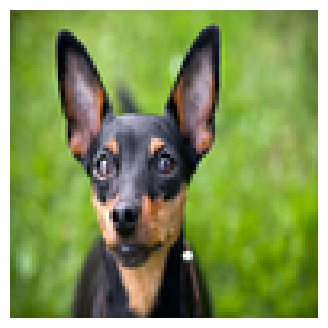

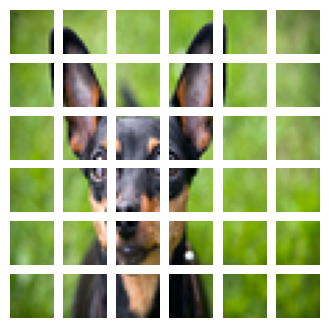

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

Реализация слоя кодирования патчей

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


Функция для построения модели

In [ ]:
def create_classifier():
    inputs = keras.Input(shape=(96, 96, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


Создание, обучение и оценка модели

In [ ]:
model_transformer = create_classifier()


In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model_transformer.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [ ]:
checkpoint_filepath = "/content/drive/MyDrive/model_transformer_checkpoint.weights.h5"

my_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5),
    callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True,save_weights_only=True)
]

In [ ]:
history = model_transformer.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=my_callbacks,
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.2033 - loss: 4.1182 - top-5-accuracy: 1.0000 - val_accuracy: 0.2200 - val_loss: 3.6310 - val_top-5-accuracy: 1.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2270 - loss: 4.7743 - top-5-accuracy: 1.0000 - val_accuracy: 0.2400 - val_loss: 2.0891 - val_top-5-accuracy: 1.0000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.2356 - loss: 2.9721 - top-5-accuracy: 1.0000 - val_accuracy: 0.3200 - val_loss: 1.7499 - val_top-5-accuracy: 1.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2993 - loss: 2.2420 - top-5-accuracy: 1.0000 - val_accuracy: 0.2600 - val_loss: 1.6047 - val_top-5-accuracy: 1.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.2683 - loss: 2.1161 - top-5-accuracy: 1.0000 - val_accuracy: 0.2200 - val_loss: 1.7130 - val_top-5-accuracy: 1.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3231 - loss: 1.8308 - top-5-accuracy: 1.0000 - val

In [ ]:
model_transformer.load_weights(checkpoint_filepath)

In [ ]:
# Save the final model
model_transformer.save("/content/drive/MyDrive/model_transformer.keras")

In [ ]:
_, accuracy, top_5_accuracy = model_transformer.evaluate(X_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.3136 - loss: 1.5820 - top-5-accuracy: 1.0000
Test accuracy: 30.61%


## **Задание 4**

Вычислим и выводим в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) **для тестовой выборки**

In [ ]:
from sklearn.metrics import confusion_matrix

pred1_labels = model_MLP.predict(X_test)
pred1_labels = np.argmax(pred1_labels, axis=1)
#pred1_labels = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred1_labels)]).reshape((y_test.shape[0], num_classes))[::,1]

pred2_labels = model_transformer.predict(X_test)
pred2_labels = np.argmax(pred2_labels, axis=1)
#pred2_labels = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred2_labels)]).reshape((y_test.shape[0], num_classes))[::,1]

pred1_labels.shape, pred2_labels.shape, y_test.shape

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step


((343,), (343,), (343,))

In [ ]:
cm1 = confusion_matrix(y_test, pred1_labels)
cm2 = confusion_matrix(y_test, pred2_labels)

In [ ]:
import seaborn as sns

def plot_confusion_matrix(data, labels, output_filename):
    """Визуализация матрицы ошибок при помощи heatmap

    Аргументы:
        data (список списков): матрица ошибок (confusion matrix)
        labels (список): Метки для осей x и y
        output_filename (текст): Путь к выходному файлу

    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))

    sns.set(font_scale=1.3)
    ax = sns.heatmap(data, annot=True, cmap="Blues",
                     cbar_kws={'label': 'Шкала'},fmt='d')

    ax.set_xticklabels(labels, fontsize = 16)
    ax.set_yticklabels(labels, fontsize = 16)

    ax.set_xlabel("Прогнозные метки", fontsize = 16)
    ax.set_ylabel("Истинные метки", fontsize = 16)

    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

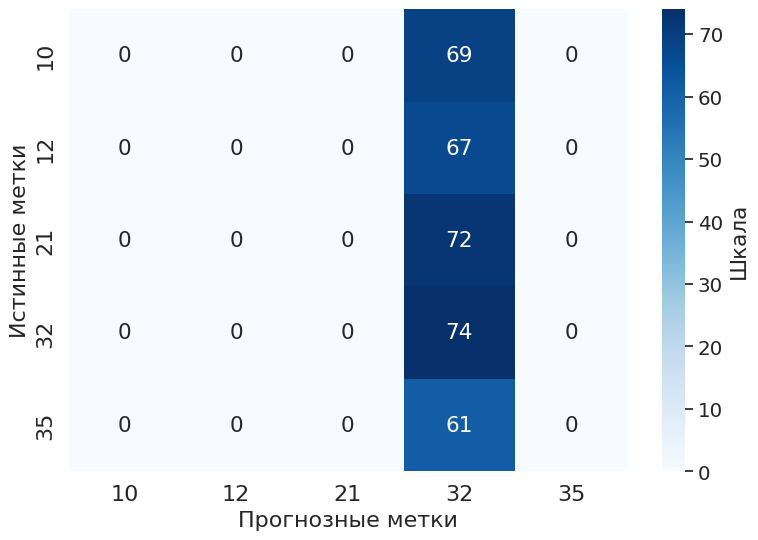

In [ ]:
plot_confusion_matrix(cm1, [10, 12, 21, 32, 35], "confusion_matrix1.png")

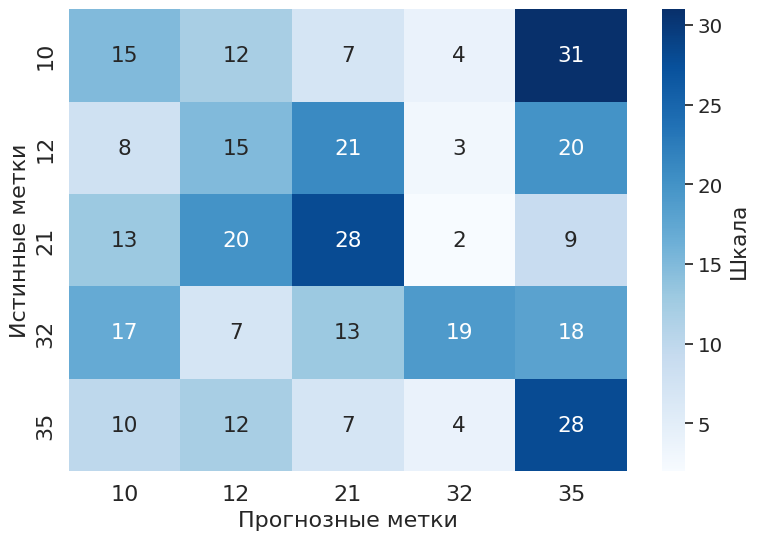

In [ ]:
plot_confusion_matrix(cm2, [10, 12, 21, 32, 35], "confusion_matrix2.png")

Вычислим и выводим в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) **для обучающей выборки**

In [ ]:
pred3_labels = model_MLP.predict(X_train)
pred3_labels = np.argmax(pred3_labels, axis=1)
#pred1_labels = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred1_labels)]).reshape((y_test.shape[0], num_classes))[::,1]

pred4_labels = model_transformer.predict(X_train)
pred4_labels = np.argmax(pred4_labels, axis=1)
#pred2_labels = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(pred2_labels)]).reshape((y_test.shape[0], num_classes))[::,1]

pred3_labels.shape, pred4_labels.shape, y_train.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step


((495,), (495,), (495,))

In [ ]:
cm3 = confusion_matrix(y_train, pred3_labels)
cm4 = confusion_matrix(y_train, pred4_labels)

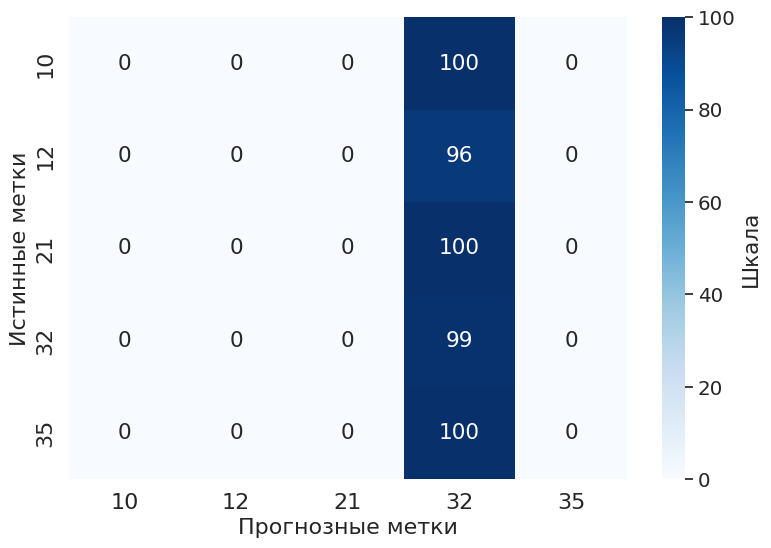

In [ ]:
plot_confusion_matrix(cm3, [10, 12, 21, 32, 35], "confusion_matrix3.png")

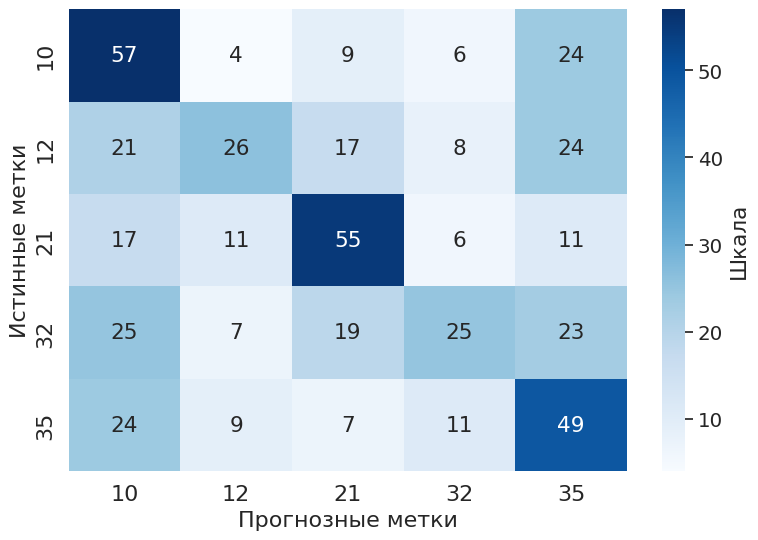

In [ ]:
plot_confusion_matrix(cm4, [10, 12, 21, 32, 35], "confusion_matrix4.png")

## **Задание 5**

Визуализируем кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

Используем для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).

In [ ]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [ ]:
minepochs = min(len(history_1.history['loss']), len(history.history['loss']))
minepochs

13

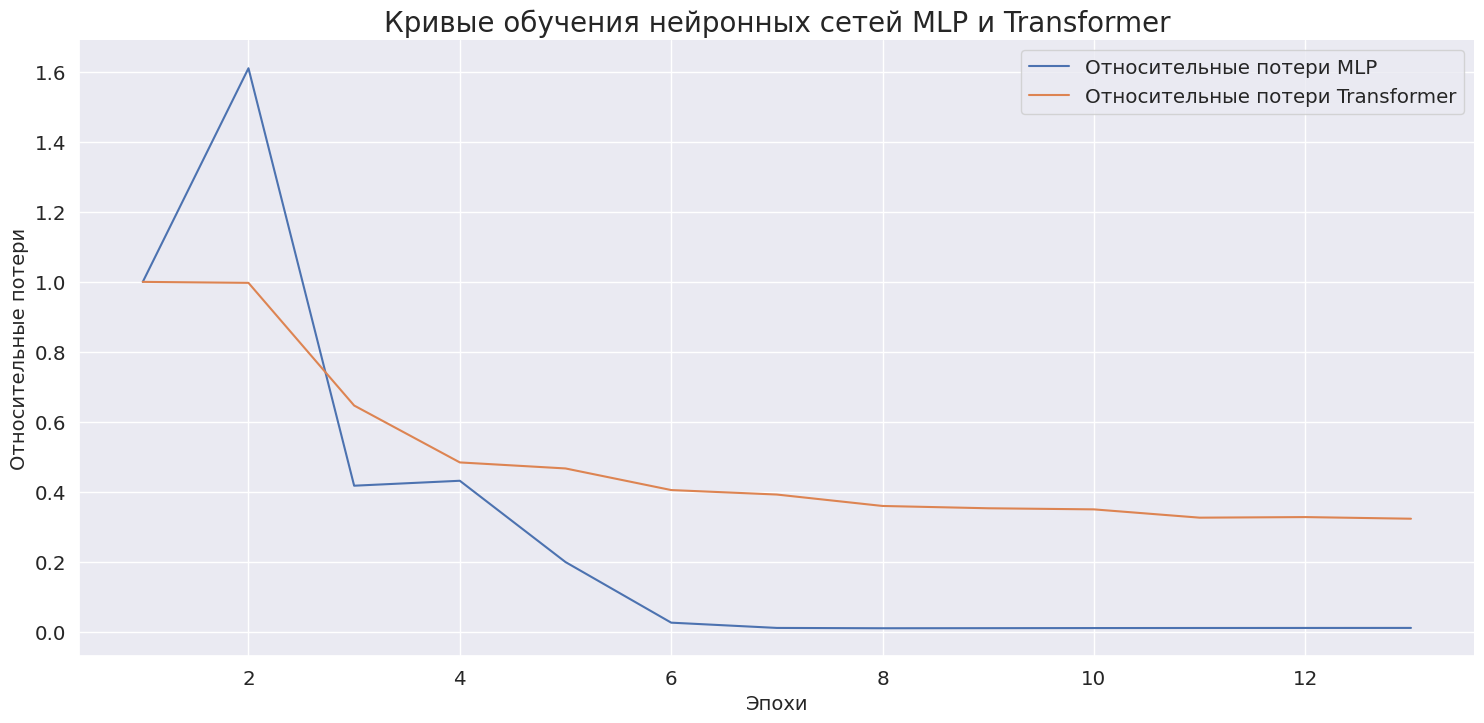

In [ ]:
plt.plot(np.arange(1, minepochs+1), np.array(history_1.history['loss'][:minepochs])/history_1.history['loss'][0], label='Относительные потери MLP')
plt.plot(np.arange(1, minepochs+1), np.array(history.history['loss'][:minepochs])/history.history['loss'][0], label='Относительные потери Transformer')
plt.title('Кривые обучения нейронных сетей MLP и Transformer', size=20)
plt.xlabel('Эпохи', size=14)
plt.ylabel('Относительные потери', size=14)
plt.legend();

## **Задание 6**

Оценим качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества min_Precision, где $Precision = \frac{TP}{TP + FP}$

Выводим название нейронной сети с лучшим качеством.

In [ ]:
Precisions1 = []
Precisions2 = []

pred1_labels = model_MLP.predict(X_test)
pred2_labels = model_transformer.predict(X_test)

for cl in selected_classes:
  m1 = keras.metrics.Precision(class_id = selected_classes.index(cl))
  m2 = keras.metrics.Precision(class_id = selected_classes.index(cl))

  m1.update_state(y_test, pred1_labels)
  m2.update_state(y_test, pred2_labels)

  Precisions1.append(m1.result())
  Precisions2.append(m2.result())

print("Минимальная точность  для модели MLP= ", min(Precisions1))
print("Минимальная точность классов для модели transformer= ", min(Precisions2))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Минимальная точность  для модели MLP=  tf.Tensor(0.0, shape=(), dtype=float32)
Минимальная точность классов для модели transformer=  tf.Tensor(0.0, shape=(), dtype=float32)


Судя по кривым обучения и качеству по показателю min Precision, можно сказать что **model_MLP есть лучшая модель**